In [216]:
#Seteamos directorio y el archivo csv con el que vamos a trabajar
directorio = r"C:\Users\Santiago\Desktop\2024\1er cuatri\Big Data\Big data - TP2"

archivo_csv = "Base Airbnb NY.csv"

#Descargo librerías
import os

import pandas as pd

#Construyo la ruta absoluta

ruta_absoluta = os.path.join(directorio, archivo_csv)

#Cargo el csv como un data frame

data_frame = pd.read_csv(ruta_absoluta)


In [217]:
#1.a) Para reconocer cuantos elementos duplicados hay, vemos la longitud del dataframe antes y despues de eliminar duplicados.
longitud_antes_de_borrar = len(data_frame)

print(longitud_antes_de_borrar)

#Elimino los duplicados. Para eso creo una nuevo archivo que se llama data_frame_sin_duplicados y pido quedarme con los valores que aparecen por primera vez

data_frame_sin_duplicados = data_frame.drop_duplicates(keep='first')

longitud_sin_duplicados = len(data_frame_sin_duplicados)

print(longitud_sin_duplicados)

#Resto las longitudes para saber cuantos datos duplicados habia:

longitud_antes_de_borrar - longitud_sin_duplicados


48905
48895


10

In [218]:
#1)b)
#Eliminamos columnas que no tienen información relevante
#Con el siguiente comando vemos que columnas tiene:
print(data_frame.head())
print(data_frame.columns)
columnas_a_eliminar = ['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'last_review', 'room_type', 'neighbourhood_group']
data_frame_modificado = data_frame_sin_duplicados.drop(columns=columnas_a_eliminar)
#Guardamos el nuevo data frame
data_frame_modificado.to_csv('datos_sin_duplicados_sin_columnas.csv', index=False)
#Decidimos eliminar estas variables porque consideramos que no aportan informacion relevante al analisis de los datos, tambien neighbourhood group y room type los descartamos porque al ser strings complicaban mucho las cuentas.Las columnas, neighbourhood_type y room type fueron sacadas ya que eran strings y complicaban las cuentas. Neighbourhood_type igual esta tomada encuenta en latitud y longitud en una forma mas exacta y el room type no tiene un valor similar que fue tenido en cuenta pero creemos que la cantidad de columnas y el n grande que tenemos puede ayudar a eliminar el sesgo
print(data_frame_modificado)
print(data_frame_modificado.columns)

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room  149.0               1                  9  20

In [219]:
#1)c) Buscamos las columnas con missing values
missing_values = data_frame_modificado.columns[data_frame_modificado.isnull().any()]
print("Columnas con valores faltantes:")
print(missing_values)

#completamos los missing values
"""nuestra idea aca es completar los datos faltantes a traves de una funcion de KNN, la idea es llenar los datos faltantes con datos que sean una representacion del modelo obtenido. comprendemos que podemos estar sesgando el porque estos datos no se muestran como precios muy alto o muy pocas reviews en el ultimo mes. Aun asi creemos que esta funcion nos da una estimacion confiable para tomar valores que representen estos datos."""

import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split


#  definimos nuestras variables a aproximar y las columnas que sera tenidas en cuenta para hacer esta estimacion.
caracteristicas_precio = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
caracteristicas_reviews = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']

# armamos nuestras variables para la funcion KNN
X_precio = data_frame_modificado[caracteristicas_precio]
y_precio = data_frame_modificado['price']
X_reviews = data_frame_modificado[caracteristicas_reviews]
y_reviews = data_frame_modificado['reviews_per_month']


X_train_precio, X_test_precio, y_train_precio, y_test_precio = train_test_split(X_precio, y_precio, test_size=0.2, random_state=42)
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_reviews, y_reviews, test_size=0.2, random_state=42)

# Definimos el imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Imputamos los valores faltantes para 'precio' y 'reviews_por_mes'
X_train_precio_imputed = imputer.fit_transform(X_train_precio)
X_train_reviews_imputed = imputer.fit_transform(X_train_reviews)

# Actualizamos los DataFrames con los valores imputados
X_train_precio_imputed = pd.DataFrame(X_train_precio_imputed, columns=caracteristicas_precio)
X_train_reviews_imputed = pd.DataFrame(X_train_reviews_imputed, columns=caracteristicas_reviews)

# Comprobamos que ya no hay valores faltantes
print("Valores faltantes en 'precio':", X_train_precio_imputed.isnull().sum().sum())
print("Valores faltantes en 'reviews_por_mes':", X_train_reviews_imputed.isnull().sum().sum())

# Guardamos los DataFrames con los valores imputados
X_train_precio_imputed.to_csv('X_train_precio_imputed.csv', index=False)
X_train_reviews_imputed.to_csv('X_train_reviews_imputed.csv', index=False)

Columnas con valores faltantes:
Index(['price', 'reviews_per_month'], dtype='object')
Valores faltantes en 'precio': 0
Valores faltantes en 'reviews_por_mes': 0


In [220]:
# 1)d)
def detectar_outliers(data, columna):
    outliers = []
    Q1 = data[columna].quantile(0.01)
    Q3 = data[columna].quantile(0.99)
    IQR = Q3 - Q1
    umbral_inferior = Q1 - 1.5 * IQR
    umbral_superior = Q3 + 1.5 * IQR

    for valor in data[columna]:
        if valor < umbral_inferior or valor > umbral_superior:
            outliers.append(valor)

    return outliers

columnas = data_frame_modificado.columns

for columna in columnas:
    outliers = detectar_outliers(data_frame_modificado, columna)

    if outliers:
        print("Outliers en la columna '{}':".format(columna), outliers)

def corregir_outliers(data, columna):
    Q99 = data[columna].quantile(0.99)
    data.loc[data[columna] > Q99, columna] = Q99

columnas = data_frame_modificado.columns

for columna in columnas:
    outliers = detectar_outliers(data_frame_modificado, columna)

    if outliers:
        print("Outliers en la columna '{}':".format(columna), outliers)
        corregir_outliers(data_frame_modificado, columna)

print("Outliers corregidos.")
#lo que hicimos aca fue corregir los outliers >0.01 y <0.99 por la mediana, por mas que puede no ser preciso esto nos sirve para acomodar los valores existentes y no generar missing values.

Outliers en la columna 'price': [2000.0, 3000.0, 2000.0, 4000.0, 2500.0, 5000.0, 1999.0, 6000.0, 2000.0, 2000.0, 4000.0, 5250.0, 6500.0, 2750.0, 2500.0, 3750.0, 2300.0, 5000.0, 4500.0, 8000.0, 2695.0, 2000.0, 9999.0, 2400.0, 2000.0, 2000.0, 2000.0, 2000.0, 2000.0, 2000.0, 10000.0, 2000.0, 2000.0, 9999.0, 2000.0, 2100.0, 2500.0, 6000.0, 2000.0, 2000.0, 3800.0, 10000.0, 2350.0, 2500.0, 3000.0, 2000.0, 2000.0, 2000.0, 2590.0, 4000.0, 2250.0, 5000.0, 2800.0, 2250.0, 2000.0, 2900.0, 2500.0, 2500.0, 5000.0, 3900.0, 5000.0, 2200.0, 3000.0, 3000.0, 2010.0, 3210.0, 4160.0, 10000.0, 7703.0, 3518.0, 6419.0, 2626.0, 2103.0, 2000.0, 2500.0, 8500.0, 2990.0, 2500.0, 3750.0, 6500.0, 2545.0, 3600.0, 5000.0, 2000.0, 3000.0, 3000.0, 2999.0, 3000.0, 3200.0, 3000.0, 1999.0, 9999.0, 2500.0, 1978.0, 3512.0, 2850.0, 7500.0, 3613.0, 2600.0, 4100.0, 5100.0, 4200.0, 6800.0, 2000.0, 2500.0, 7500.0, 2500.0, 4200.0, 2995.0, 4500.0, 2000.0, 6500.0, 2999.0, 1999.0]
Outliers en la columna 'minimum_nights': [180, 200, 

In [221]:
#1)e) 
# Suponiendo que 'df' es tu DataFrame y 'variable_categorica' es la columna con las categorías
frecuencia_valores_roomt = data_frame['room_type'].value_counts()
print("Frecuencia de cada valor único:")
print(frecuencia_valores_roomt)
print(data_frame)

# Suponiendo que 'df' es tu DataFrame y 'variable_categorica' es la columna con las categorías
frecuencia_valores = data_frame['neighbourhood_group'].value_counts()
print("Frecuencia de cada valor único:")
print(frecuencia_valores)

# Crear un diccionario de mapeo para 'neighbourhood_group'
neighbourhood_group_mapping = {'Manhattan': 1, 'Brooklyn': 2, 'Queens': 3, 'Staten Island': 4, 'Bronx': 5}

# Crear un diccionario de mapeo para 'room_type'
room_type_mapping = {'Entire home/apt': 1, 'Private room': 2, 'Shared room': 3}

# Asignar valores numéricos a las columnas correspondientes
data_frame['neighbourhood_group_numeric'] = data_frame['neighbourhood_group'].map(neighbourhood_group_mapping)
data_frame['room_type_numeric'] = data_frame['room_type'].map(room_type_mapping)

# Mostrar las primeras filas del DataFrame con las nuevas variables numéricas
print(data_frame.head())

#Primero, buscamos la cantidad de barrios y de tipos de cuarto que habian. Despues pedimos que le asignen un valor numérico a cada categoría y así tenemos nuestras variables transformadas a numéricas.

Frecuencia de cada valor único:
room_type
Entire home/apt    25414
Private room       22331
Shared room         1160
Name: count, dtype: int64
             id                                               name   host_id  \
0          2539                 Clean & quiet apt home by the park      2787   
1          2595                              Skylit Midtown Castle      2845   
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
3          3831                    Cozy Entire Floor of Brownstone      4869   
4          5022   Entire Apt: Spacious Studio/Loft by central park      7192   
...         ...                                                ...       ...   
48900  19454344  Perfect ap in Manhattan! Walking to Central Park!  11670284   
48901  36224876                   Upper East Side Apt By The Water  46232598   
48902  21869051                        Comfy Apt in NYC Brownstone  97243693   
48903   3004563                                          

In [222]:
#1)f). Usar groupby para contar el número de oferentes por 'Neighbourhood group'
offer_group = data_frame.groupby('neighbourhood_group').size().reset_index(name='offer_group')

# Unir el resultado de vuelta al DataFrame original con sufijos diferentes
data_frame = data_frame.merge(offer_group, on='neighbourhood_group', how='left', suffixes=('', '_count'))

# Mostrar las primeras filas del DataFrame con la nueva columna 'offer_group'
print(data_frame.head())


     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room  149.0               1                  9  20

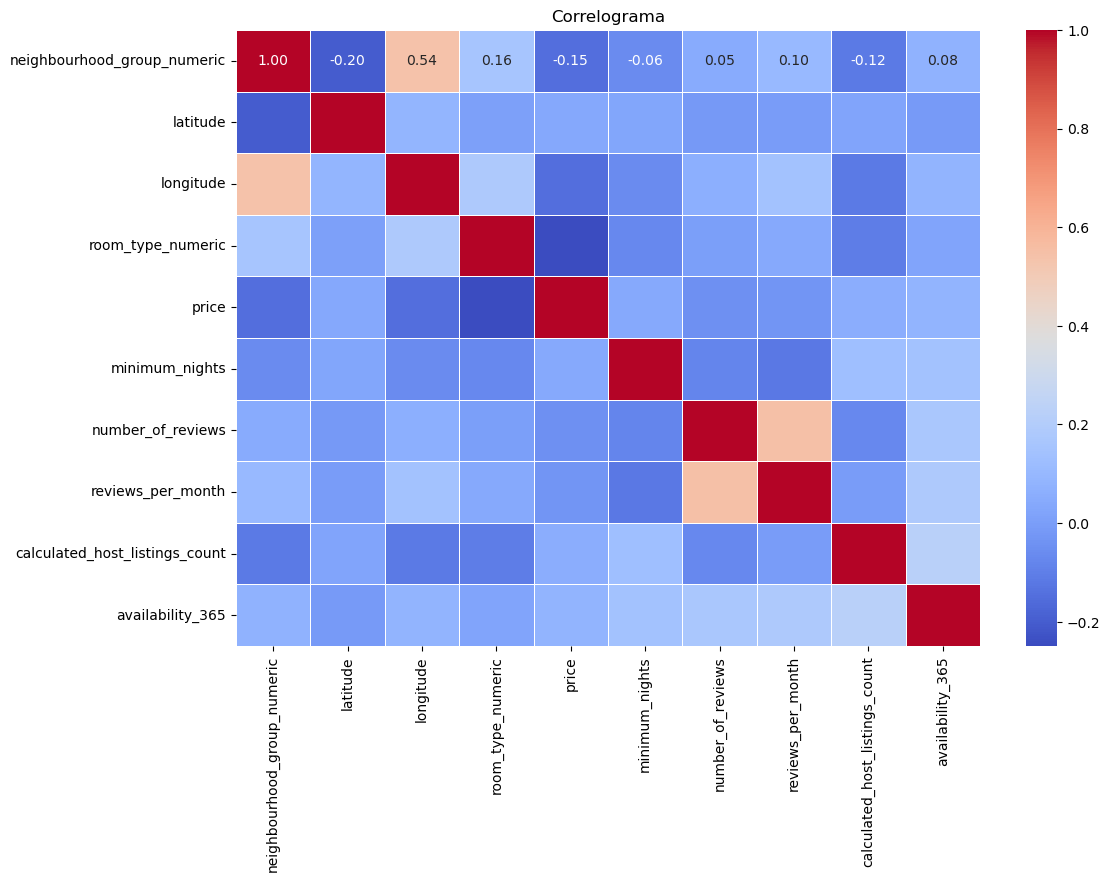

In [177]:
#2.1) 

import seaborn as sns
import matplotlib.pyplot as plt

#Elegimos las variables para las que vamos a armar la matriz de correlación
variables_para_correlograma = ['neighbourhood_group_numeric', 'latitude', 'longitude', 'room_type_numeric', 'price', 
             'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
             'calculated_host_listings_count', 'availability_365']

#Creamos un subconjunto
subconjunto_data_frame = data_frame_modificado[variables_para_correlograma]

# Calcular la matriz de correlación
correlograma = subconjunto_data_frame.corr()

#Pedimos imprimir la matriz:
plt.figure(figsize=(12, 8))
sns.heatmap(correlograma, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma')
plt.show()

In [178]:
#Podemos ver que las variables más correlacionadas son el número de reviews en total con el número de reviews por mes. Esto es lógico ya que la que tenga más reviews cada mes tendra más reviews en total. 

In [ ]:
#2.2) Calculamos la proporción de oferentes por "Neighbourhood group" y por "Room type"
proporcion_por_barrio = data_frame_modificado['neighbourhood_group'].value_counts(normalize=True)

proporcion_por_tipo_habitacion = data_frame_modificado['room_type'].value_counts(normalize=True)

#Imprimimos la proporción de oferentes por "Neighbourhood group" y por "Room type"
print("Proporción de oferentes por 'Neighbourhood group':")
print(proporcion_por_barrio)
print()

print("Proporción de oferentes por tipo de habitación:")
print(proporcion_por_tipo_habitacion)




In [ ]:
import matplotlib.pyplot as plt

# Calculamos la proporción de oferentes por "Neighbourhood group" y por "tipo de habitación"
proporcion_por_barrio = data_frame_modificado['neighbourhood_group'].value_counts(normalize=True)

proporcion_por_tipo_habitacion = data_frame_modificado['room_type'].value_counts(normalize=True)

# Creamos gráficos que muestran las proporciones
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de la proporción de oferentes por "Neighbourhood group":
axs[0].pie(proporcion_por_barrio, labels=proporcion_por_barrio.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Proporción de oferentes por "Neighbourhood group"')

# Gráfico de la proporción de oferentes por "tipo de habitación":
axs[1].pie(proporcion_por_tipo_habitacion, labels=proporcion_por_tipo_habitacion.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Proporción de oferentes por tipo de habitación')

#Pedimos que muestren los gráficos:
plt.tight_layout()
plt.show()


In [ ]:
#Encontramos que los barrios en los que más oferta hay son Brooklyn y Manhattan, con más del 40%
#Por otro lado, encontramos que casi no se ofrecen cuartos compartidos pero que si es bastante común ofrecer departamentos compartidos con cuartos separados.

In [ ]:
#2.3) 
import seaborn as sns

# Pedimos que se arme un histograma de los precios de los alojamientos y pedimos que calcule el precio mínimo, máximo y promedio
plt.figure(figsize=(10, 6))
sns.histplot(data_frame_modificado['price'], bins=35, kde=True, color='skyblue')
plt.title('Histograma de precios de alojamientos')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()
precio_minimo = data_frame_modificado['price'].min()
precio_maximo = data_frame_modificado['price'].max()
precio_promedio = data_frame_modificado['price'].mean()

# Calcular la media de precio por "Neighbourhood group" y por "Tipo de habitación":
media_precio_por_barrio = data_frame_modificado.groupby('neighbourhood_group')['price'].mean()

media_precio_por_tipo_habitacion = data_frame_modificado.groupby('room_type')['price'].mean()

# Imprimimos los resultados
print(f"Precio mínimo: {precio_minimo}")
print(f"Precio máximo: {precio_maximo}")
print(f"Precio promedio: {precio_promedio}")
print("\nMedia de precio por 'Neighbourhood group':")
print(media_precio_por_barrio)
print("\nMedia de precio por tipo de habitación:")
print(media_precio_por_tipo_habitacion)


In [ ]:
#2.4) 
#Scatter plot N1: Neighbourhood group vs Price

import seaborn as sns
import matplotlib.pyplot as plt

# Crear el scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='neighbourhood_group', y='price', data=data_frame_modificado)
plt.xlabel('Grupo de vecindarios')
plt.ylabel('Precio')
plt.title('Scatter Plot: Grupo de vecindarios vs. Precio')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad
plt.show()

#Podemos ver que tanto Brooklyn como Manhattan son los que tienen más observaciones y los que tienen más observaciones con precios más altos. El Bronx tiene menos observaciones y con el precio más bajo.

#Scatter plot N1: Neighbourhood group vs Price

import seaborn as sns
import matplotlib.pyplot as plt

# Crear el scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minimum_nights', y='number_of_reviews', data=data_frame_modificado)
plt.xlabel('Mínimo de noches')
plt.ylabel('Número de reseñas')
plt.title('Scatter Plot: Mínimo de noches vs. Número de reseñas')
plt.show()

#Podemos ver que los que tienen más un número de noches mínimas mayor tienen menos reviews. Esto puede ser porque hay menos personas que alquilan por muhcas noches que las que alquilan por pocas ya que es comoún usar Airbnb para vacaciones.



In [ ]:
# Seleccionar las variables para el PCA
variables_pca = ['latitude', 'longitude', 'price', 'minimum_nights',
                 'number_of_reviews', 'reviews_per_month',
                 'calculated_host_listings_count', 'availability_365']

# Preprocesamiento: estandarizar las variables
scaler = StandardScaler()
datos_estandarizados = scaler.fit_transform(data_frame_modificado[variables_pca])

# Realizar PCA
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(datos_estandarizados)

# Porcentaje de varianza explicada por las dos componentes principales
varianza_explicada = pca.explained_variance_ratio_
print("Porcentaje de varianza explicada por dos componentes:", sum(varianza_explicada)*100)

# Crear un DataFrame para los loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=variables_pca)

# Graficar las variables en dos dimensiones usando las dos primeras componentes principales
plt.figure(figsize=(10, 6))
plt.scatter(componentes_principales[:, 0], componentes_principales[:, 1], alpha=0.5)
plt.title('Variables en dos dimensiones (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Anotar los loadings en el gráfico
for variable, (pc1, pc2) in loadings.iterrows():
    plt.annotate(variable,(pc1, pc2), color='red')

plt.grid(True)
plt.show()

In [ ]:
#2.5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Seleccionamos las variables para el análisis de componentes principales
variables = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

# Subconjunto de datos con las características seleccionadas
subset_data = data_frame_modificado[variables]

# Normalizamos los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Aplicamos PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Pedimos la varianza explicada por los componentes principales
explained_variance_ratio = pca.explained_variance_ratio_
print("Varianza explicada por los dos componentes principales:", explained_variance_ratio.sum())

# Graficamos los datos en dos dimensiones
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Análisis de Componentes Principales (PCA)')
plt.grid(True)
plt.show()


In [236]:
#3)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Definir las características (X) y la variable objetivo (y)
X = data_frame_modificado.drop('price', axis=1)  # Seleccionar todas las columnas excepto 'price' como características
y = data_frame_modificado['price']  # Seleccionar la columna 'price' como variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir los precios en el conjunto de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de entrenamiento y prueba
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Calcular el coeficiente de determinación (R^2) en el conjunto de entrenamiento y prueba
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Comentar los resultados obtenidos
print("Error cuadrático medio (MSE) en conjunto de entrenamiento:", train_mse)
print("Error cuadrático medio (MSE) en conjunto de prueba:", test_mse)
print("Coeficiente de determinación (R^2) en conjunto de entrenamiento:", train_r2)
print("Coeficiente de determinación (R^2) en conjunto de prueba:", test_r2)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values